# importing **lib**

Dataset link
https://www.kaggle.com/datasets/ahmedashrafahmed/bone-fracture

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from google.colab import drive
import os
import hashlib
from PIL import Image
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Directory paths
base_dir = '/content/drive/MyDrive/boneFracture/dataset'
train_dir = base_dir + '/train'
val_dir = base_dir + '/val'
test_dir = base_dir + '/test'

# **EDA**

In [ ]:
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [ ]:
train = data(train_dir)
val = data(val_dir)
test = data(test_dir)


## Visualizing our data

In [ ]:

# prompt: distribution of the classes

import os

def count_classes(directory):
  class_counts = {}
  for class_name in os.listdir(directory):
    class_path = os.path.join(directory, class_name)
    if os.path.isdir(class_path):
      class_counts[class_name] = len(os.listdir(class_path))
  return class_counts

train_counts = count_classes(train_dir)
val_counts = count_classes(val_dir)
test_counts = count_classes(test_dir)

print("Training set distribution:", train_counts)
print("Validation set distribution:", val_counts)
print("Test set distribution:", test_counts)


Training set distribution: {'fractured': 2078, 'not fractured': 2019}
Validation set distribution: {'fractured': 168, 'not fractured': 236}
Test set distribution: {'fractured': 199, 'not fractured': 200}


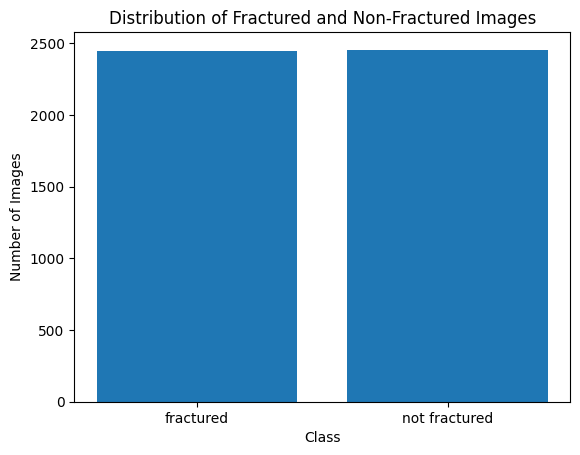

fractured: 2445 images
not fractured: 2455 images


In [ ]:
# prompt: distribution of fractured and non fractured and visualize

import matplotlib.pyplot as plt

# Combine counts from all sets
all_counts = {'fractured': train_counts.get('fractured', 0) + val_counts.get('fractured', 0) + test_counts.get('fractured', 0),
              'not fractured': train_counts.get('not fractured', 0) + val_counts.get('not fractured', 0) + test_counts.get('not fractured', 0)}

# Plot the distribution
plt.bar(all_counts.keys(), all_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Fractured and Non-Fractured Images')
plt.show()

# Print the exact numbers
for class_name, count in all_counts.items():
    print(f"{class_name}: {count} images")


# **Displaying our images**

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm

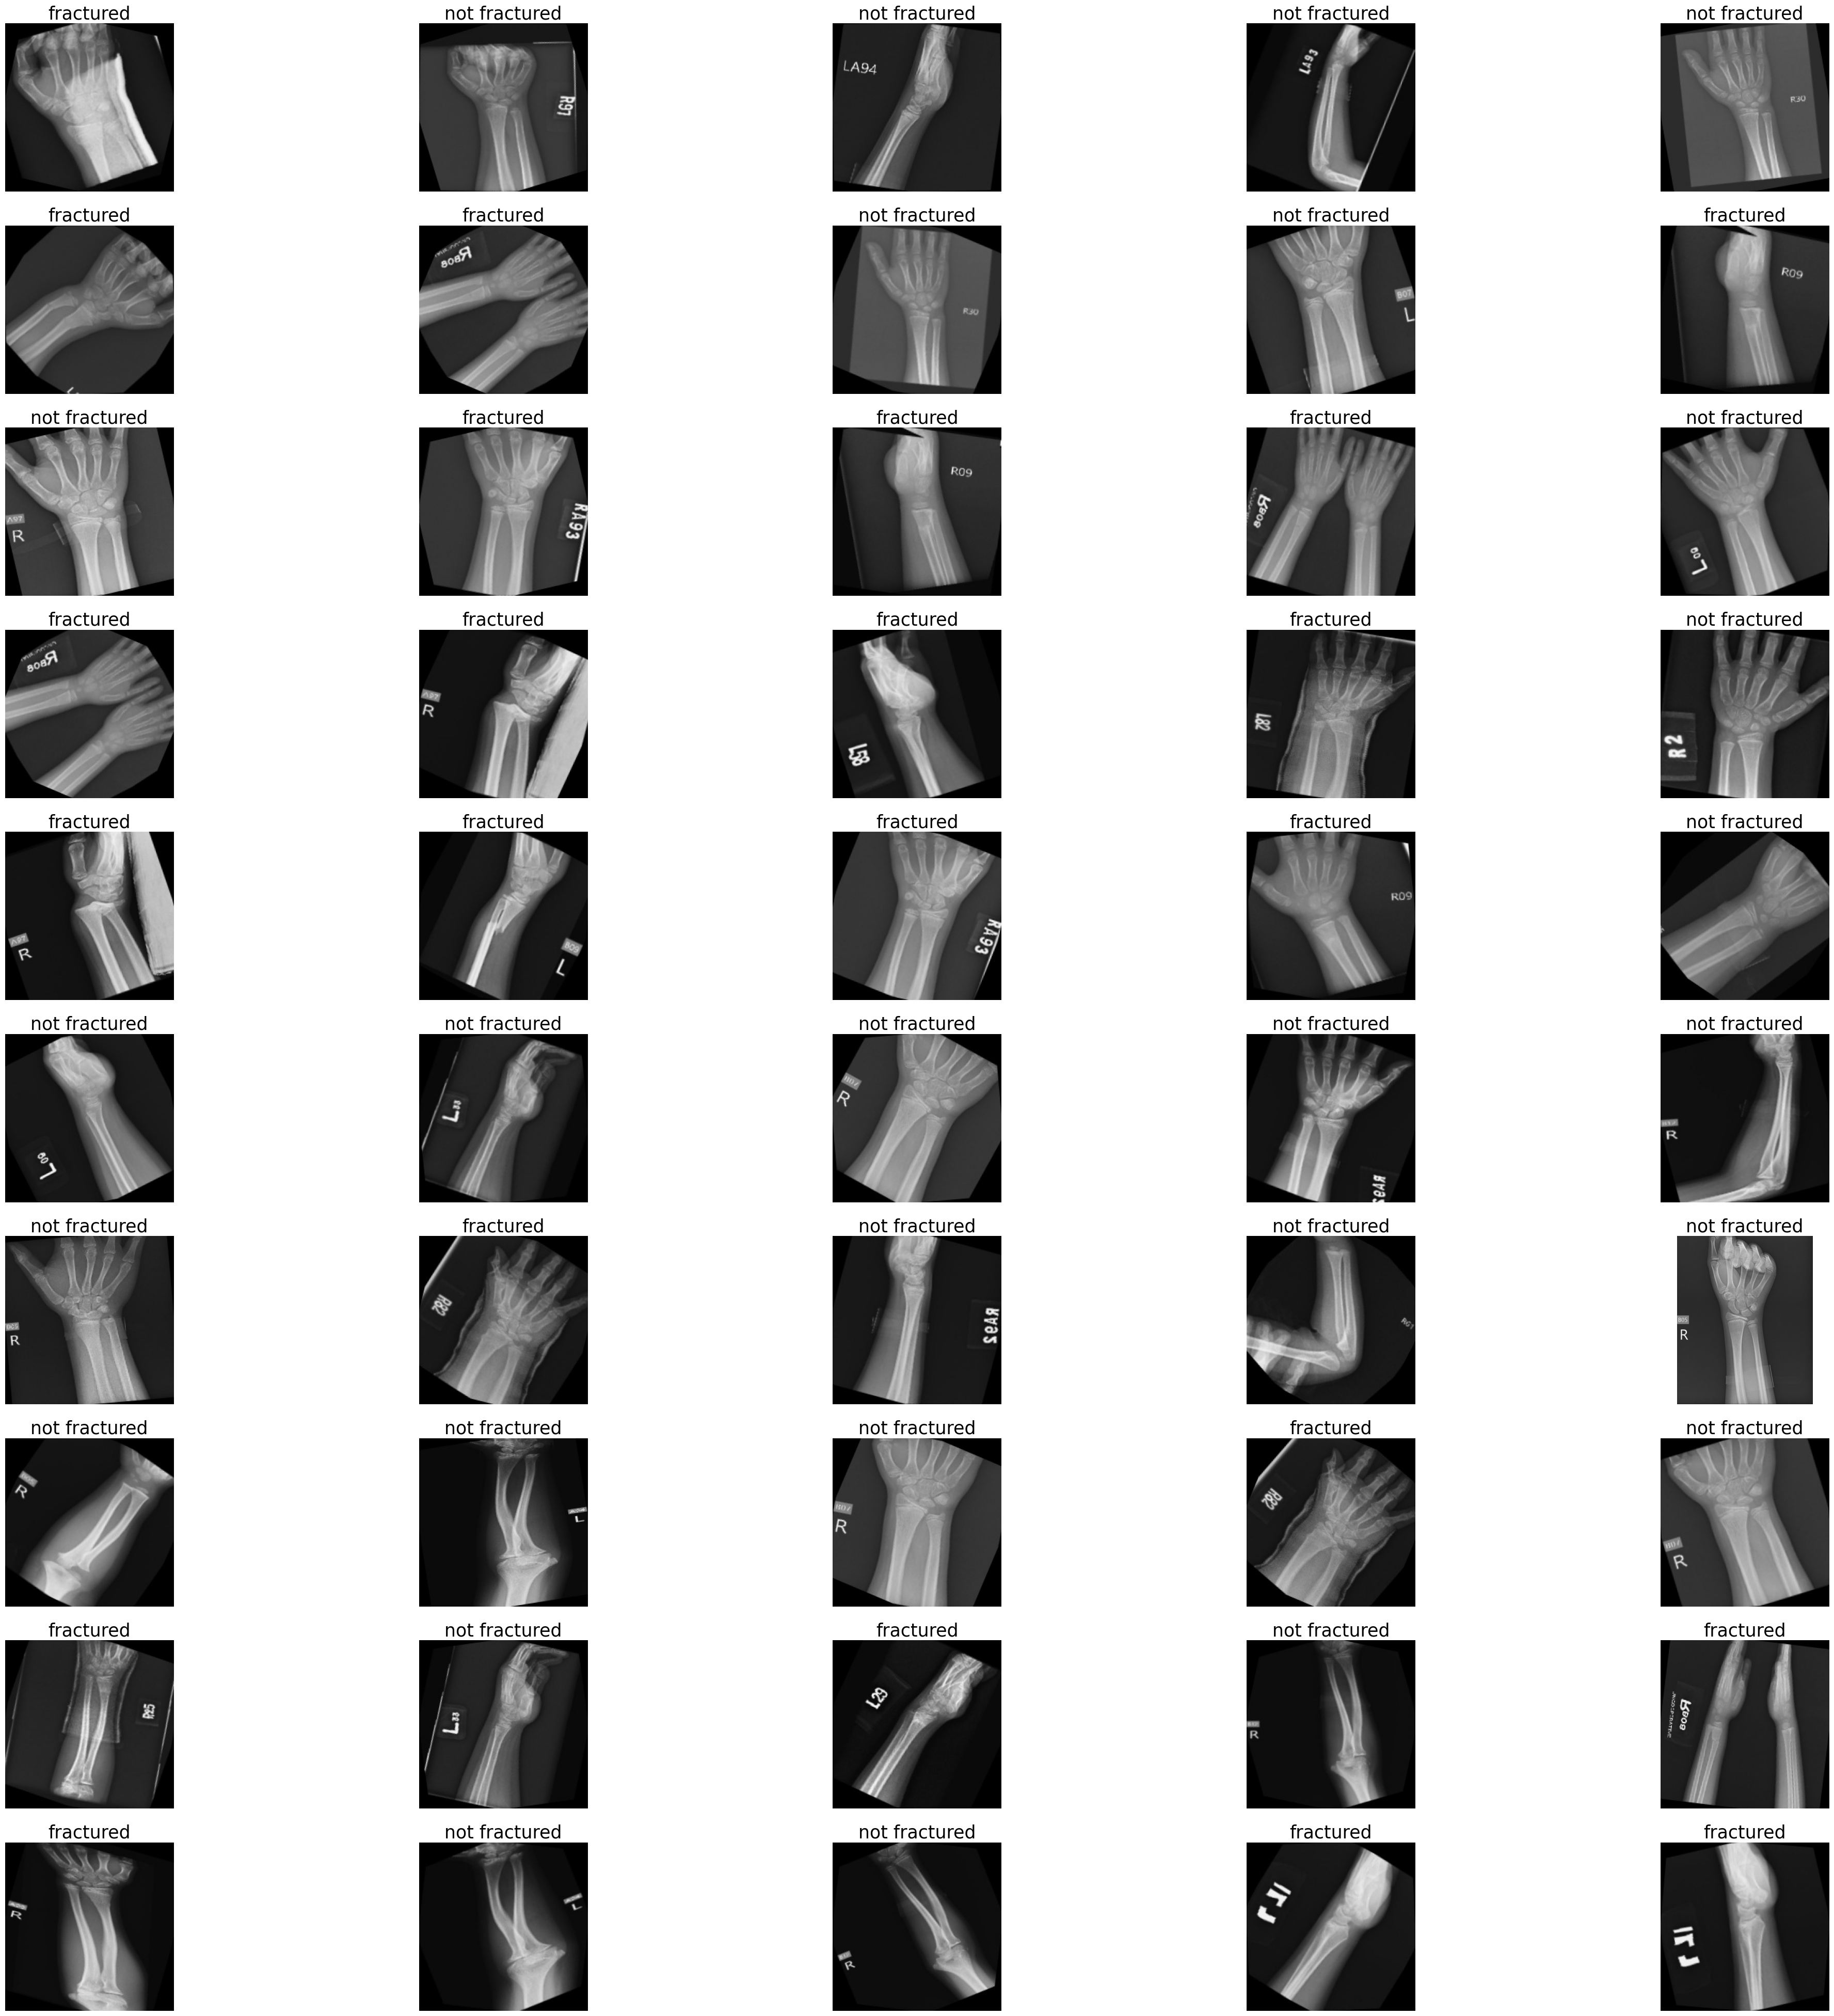

In [ ]:

plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(train),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(train.image[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title(train.label[i],fontsize=25)

# **Data Generators**

In [ ]:
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_dataframe(
    train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 4097 validated image filenames belonging to 2 classes.
Found 399 validated image filenames belonging to 2 classes.
Found 404 validated image filenames belonging to 2 classes.


# **ResNet_50**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in resnet_base_model.layers:
    layer.trainable = False

resnet_model = Sequential()
resnet_model.add(resnet_base_model)
resnet_model.add(GlobalAveragePooling2D())
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

resnet_history = resnet_model.fit(train_generator, epochs=10, validation_data=val_generator)

# Fine-tuning ResNet50 model by unfreezing some layers
for layer in resnet_base_model.layers[-10:]:
    layer.trainable = True

resnet_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

fine_tuned_resnet_history = resnet_model.fit(train_generator, epochs=10, validation_data=val_generator)


94765736/94765736 [==============================] - 6s 0us/step
Epoch 1/10
129/129 [==============================] - 22s 130ms/step - loss: 0.6897 - accuracy: 0.5292 - val_loss: 0.7029 - val_accuracy: 0.4158
Epoch 2/10
129/129 [==============================] - 15s 114ms/step - loss: 0.6739 - accuracy: 0.5768 - val_loss: 0.6766 - val_accuracy: 0.4604
Epoch 3/10
129/129 [==============================] - 15s 118ms/step - loss: 0.6613 - accuracy: 0.5997 - val_loss: 0.6874 - val_accuracy: 0.4183
Epoch 4/10
129/129 [==============================] - 15s 119ms/step - loss: 0.6568 - accuracy: 0.6034 - val_loss: 0.6637 - val_accuracy: 0.4802
Epoch 5/10
129/129 [==============================] - 15s 112ms/step - loss: 0.6426 - accuracy: 0.6563 - val_loss: 0.6374 - val_accuracy: 0.7327
Epoch 6/10
129/129 [==============================] - 15s 114ms/step - loss: 0.6334 - accuracy: 0.6639 - val_loss: 0.6166 - val_accuracy: 0.7426
Epoch 7/10
129/129 [==============================] - 15s 114ms/s

In [ ]:
# Evaluate ResNet50 model on the test set
test_loss, test_accuracy = resnet_model.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

test_preds = resnet_model.predict(test_generator)
test_preds = (test_preds > 0.5).astype(int)  # Use the built-in 'int'

test_labels = test_generator.classes

print('Classification Report')
print(classification_report(test_labels, test_preds, target_names=test_generator.class_indices.keys()))

print('Confusion Matrix')
print(confusion_matrix(test_labels, test_preds))

accuracy = accuracy_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)

print(f'Accuracy: {accuracy}')
print(f'F1 score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

13/13 [==============================] - 2s 150ms/step - loss: 0.1836 - accuracy: 0.9198
Test loss: 0.18360909819602966
Test accuracy: 0.9197995066642761
13/13 [==============================] - 3s 101ms/step
Classification Report
               precision    recall  f1-score   support

    fractured       0.99      0.85      0.91       199
not fractured       0.87      0.99      0.93       200

     accuracy                           0.92       399
    macro avg       0.93      0.92      0.92       399
 weighted avg       0.93      0.92      0.92       399

Confusion Matrix
[[169  30]
 [  2 198]]
Accuracy: 0.9197994987468672
F1 score: 0.9252336448598131
Precision: 0.868421052631579
Recall: 0.99


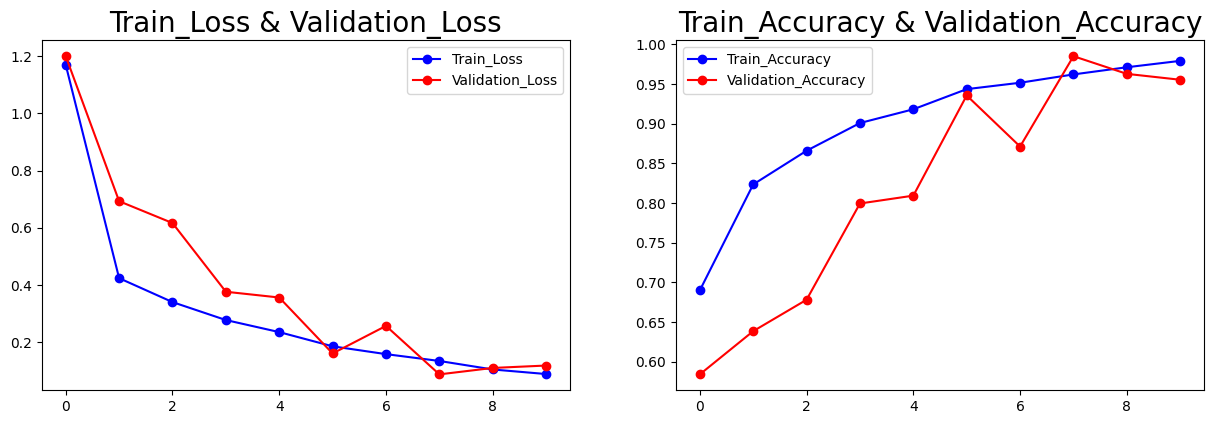

In [ ]:
# Access the training history correctly
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(fine_tuned_resnet_history.history['loss'],'b-o',label='Train_Loss') # Use history.history to access the metrics
plt.plot(fine_tuned_resnet_history.history['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(2,2,2)
plt.plot(fine_tuned_resnet_history.history['accuracy'],'b-o',label='Train_Accuracy')
plt.plot(fine_tuned_resnet_history.history['val_accuracy'],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
# Check if 'specificity_at_sensitivity' and 'auc' are available in your history
if 'specificity_at_sensitivity' in history.history:
    plt.subplot(2,2,3)
    plt.plot(fine_tuned_resnet_history.history['specificity_at_sensitivity'],'b-o',label='Train_specificity_at_sensitivity')
    plt.plot(fine_tuned_resnet_history.history['val_specificity_at_sensitivity'],'r-o',label='Validation_specificity_at_sensitivity')
    plt.title('Train_Sensitivity & Validation_Sensitivity',fontsize=20)
    plt.legend()
if 'auc' in fine_tuned_resnet_history.history:
    plt.subplot(2,2,4)
    plt.plot(fine_tuned_resnet_history.history['auc'],'b-o',label='Train_auc')
    plt.plot(fine_tuned_resnet_history.history['val_auc'],'r-o',label='Validation_auc')
    plt.title('Train_AUC & Validation_AUC',fontsize=20)
    plt.legend()
plt.show()

# VGG-**16**

In [ ]:
# Load and fine-tune the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom top layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
history = model.fit(train_generator, epochs=10, validation_data=val_generator)


Epoch 1/10
129/129 [==============================] - 1326s 10s/step - loss: 0.5024 - accuracy: 0.7452 - val_loss: 0.3227 - val_accuracy: 0.8688
Epoch 2/10
129/129 [==============================] - 31s 243ms/step - loss: 0.1379 - accuracy: 0.9480 - val_loss: 0.0531 - val_accuracy: 0.9777
Epoch 3/10
129/129 [==============================] - 32s 249ms/step - loss: 0.0706 - accuracy: 0.9766 - val_loss: 0.0622 - val_accuracy: 0.9703
Epoch 4/10
129/129 [==============================] - 32s 248ms/step - loss: 0.0385 - accuracy: 0.9866 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 5/10
129/129 [==============================] - 32s 246ms/step - loss: 0.0082 - accuracy: 0.9968 - val_loss: 3.6036e-04 - val_accuracy: 1.0000
Epoch 6/10
129/129 [==============================] - 32s 246ms/step - loss: 2.5113e-04 - accuracy: 1.0000 - val_loss: 9.2885e-05 - val_accuracy: 1.0000
Epoch 7/10
129/129 [==============================] - 32s 245ms/step - loss: 6.7362e-05 - accuracy: 1.0000 - val_loss:

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
# Evaluate ResNet50 model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

# Predictions and metrics for the test set
test_preds = model.predict(test_generator)
test_preds = (test_preds > 0.5).astype(int) # Use the built-in 'int' instead of 'np.int'

test_labels = test_generator.classes

print('Classification Report')
print(classification_report(test_labels, test_preds, target_names=test_generator.class_indices.keys()))

print('Confusion Matrix')
print(confusion_matrix(test_labels, test_preds))

accuracy = accuracy_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)

print(f'Accuracy: {accuracy}')
print(f'F1 score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

13/13 [==============================] - 243s 20s/step - loss: 3.6869e-05 - accuracy: 1.0000
Test loss: 3.6868746974505484e-05
Test accuracy: 1.0
13/13 [==============================] - 1s 100ms/step
Classification Report
               precision    recall  f1-score   support

    fractured       1.00      1.00      1.00       199
not fractured       1.00      1.00      1.00       200

     accuracy                           1.00       399
    macro avg       1.00      1.00      1.00       399
 weighted avg       1.00      1.00      1.00       399

Confusion Matrix
[[199   0]
 [  0 200]]
Accuracy: 1.0
F1 score: 1.0
Precision: 1.0
Recall: 1.0


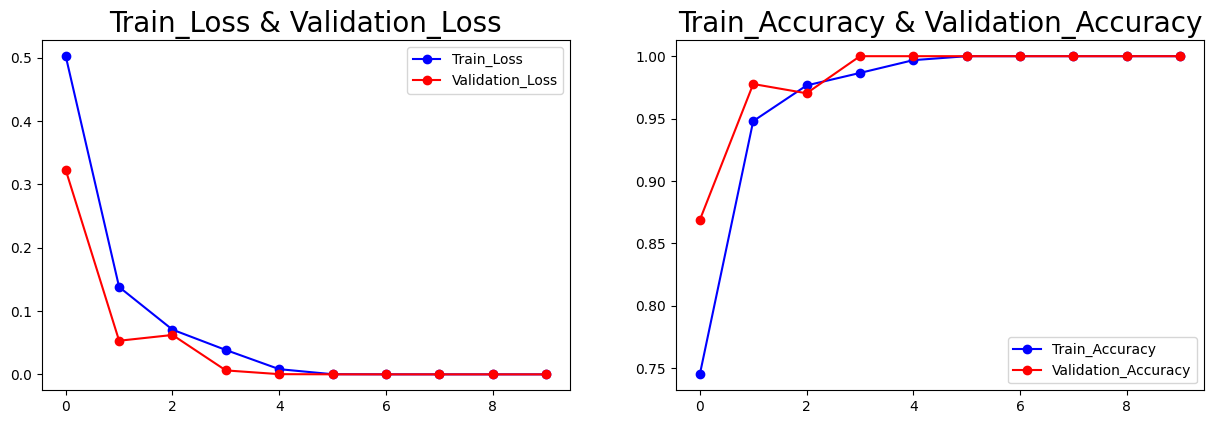

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(history.history['loss'],'b-o',label='Train_Loss') # Use history.history to access the metrics
plt.plot(history.history['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(2,2,2)
plt.plot(history.history['accuracy'],'b-o',label='Train_Accuracy')
plt.plot(history.history['val_accuracy'],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
# Check if 'specificity_at_sensitivity' and 'auc' are available in your history
if 'specificity_at_sensitivity' in history.history:
    plt.subplot(2,2,3)
    plt.plot(history.history['specificity_at_sensitivity'],'b-o',label='Train_specificity_at_sensitivity')
    plt.plot(history.history['val_specificity_at_sensitivity'],'r-o',label='Validation_specificity_at_sensitivity')
    plt.title('Train_Sensitivity & Validation_Sensitivity',fontsize=20)
    plt.legend()
if 'auc' in history.history:
    plt.subplot(2,2,4)
    plt.plot(history.history['auc'],'b-o',label='Train_auc')
    plt.plot(history.history['val_auc'],'r-o',label='Validation_auc')
    plt.title('Train_AUC & Validation_AUC',fontsize=20)
    plt.legend()
plt.show()

# **Custom Cnn model**

In [ ]:

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# Build a CNN model from scratch
image_size = (224, 224)
img_height, img_width = image_size
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the model
cnn_history = cnn_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)

Epoch 1/10
129/129 [==============================] - 19s 122ms/step - loss: 0.4011 - accuracy: 0.8404 - val_loss: 5.2055 - val_accuracy: 0.5842
Epoch 2/10
129/129 [==============================] - 15s 113ms/step - loss: 0.1474 - accuracy: 0.9483 - val_loss: 12.5067 - val_accuracy: 0.5842
Epoch 3/10
129/129 [==============================] - 14s 111ms/step - loss: 0.0790 - accuracy: 0.9768 - val_loss: 19.7074 - val_accuracy: 0.5842
Epoch 4/10
129/129 [==============================] - 15s 113ms/step - loss: 0.0633 - accuracy: 0.9795 - val_loss: 16.0327 - val_accuracy: 0.5866
Epoch 5/10
129/129 [==============================] - 15s 114ms/step - loss: 0.0467 - accuracy: 0.9871 - val_loss: 10.1288 - val_accuracy: 0.6436
Epoch 6/10
129/129 [==============================] - 15s 115ms/step - loss: 0.0343 - accuracy: 0.9927 - val_loss: 5.0769 - val_accuracy: 0.7104
Epoch 7/10
129/129 [==============================] - 16s 121ms/step - loss: 0.0239 - accuracy: 0.9956 - val_loss: 3.9903 - va

In [ ]:
# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

# Predictions and metrics for the test set
test_preds = cnn_model.predict(test_generator)
test_preds = (test_preds > 0.5).astype(int)
test_labels = test_generator.classes

print('Classification Report')
print(classification_report(test_labels, test_preds, target_names=test_generator.class_indices.keys()))

print('Confusion Matrix')
print(confusion_matrix(test_labels, test_preds))

accuracy = accuracy_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)

print(f'Accuracy: {accuracy}')
print(f'F1 score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

13/13 [==============================] - 2s 113ms/step - loss: 2.4148 - accuracy: 0.7118
Test loss: 2.41475248336792
Test accuracy: 0.7117794752120972
13/13 [==============================] - 2s 101ms/step
Classification Report
               precision    recall  f1-score   support

    fractured       0.78      0.58      0.67       199
not fractured       0.67      0.84      0.75       200

     accuracy                           0.71       399
    macro avg       0.73      0.71      0.71       399
 weighted avg       0.73      0.71      0.71       399

Confusion Matrix
[[116  83]
 [ 32 168]]
Accuracy: 0.7117794486215538
F1 score: 0.7450110864745011
Precision: 0.6693227091633466
Recall: 0.84


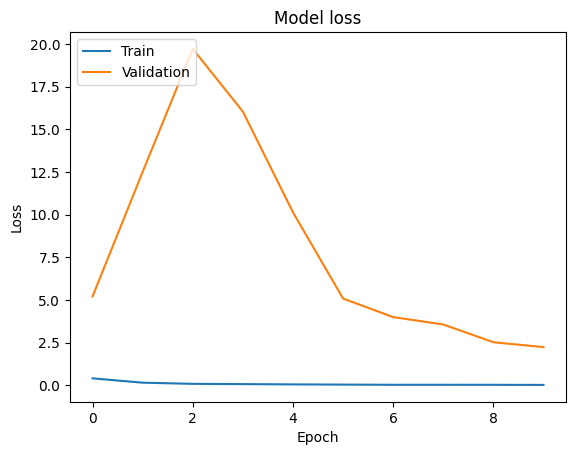

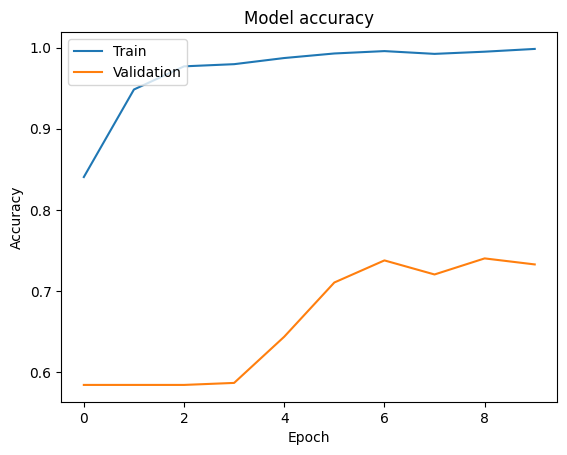

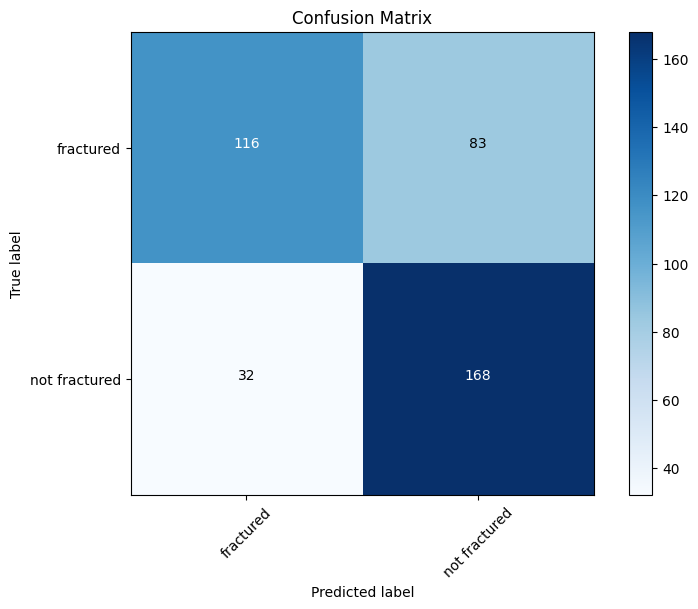

In [ ]:
# prompt: visualize the metrics

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

# Plot training & validation loss values
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# **Comparing the 3 models**



        Model  Accuracy  Validation Accuracy      Loss  Validation Loss
0  Custom CNN  0.998291             0.732673  0.015833         2.231663
1       VGG16  1.000000             1.000000  0.000016         0.000015
2    ResNet50  0.979253             0.955446  0.089537         0.119215


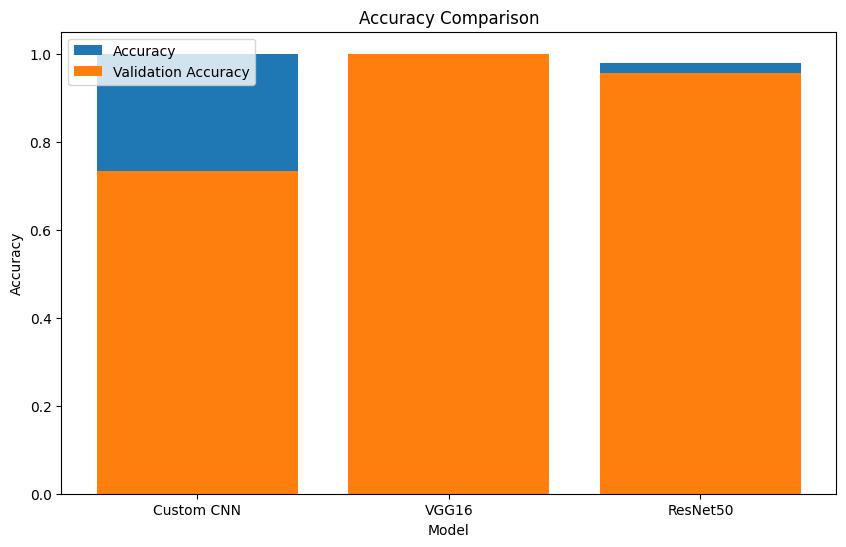

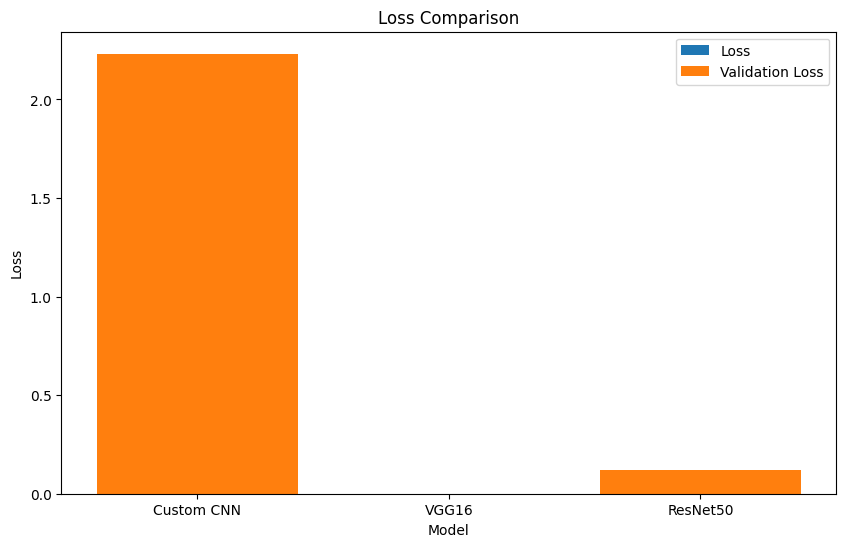

In [ ]:
# prompt: visualize the metrics and compare all three models

import pandas as pd
# Extract metrics for each model
cnn_accuracy = cnn_history.history['accuracy'][-1]
cnn_val_accuracy = cnn_history.history['val_accuracy'][-1]
cnn_loss = cnn_history.history['loss'][-1]
cnn_val_loss = cnn_history.history['val_loss'][-1]

vgg_accuracy = history.history['accuracy'][-1]
vgg_val_accuracy = history.history['val_accuracy'][-1]
vgg_loss = history.history['loss'][-1]
vgg_val_loss = history.history['val_loss'][-1]

resnet_accuracy = fine_tuned_resnet_history.history['accuracy'][-1]
resnet_val_accuracy = fine_tuned_resnet_history.history['val_accuracy'][-1]
resnet_loss = fine_tuned_resnet_history.history['loss'][-1]
resnet_val_loss = fine_tuned_resnet_history.history['val_loss'][-1]

# Create a DataFrame for comparison
metrics_df = pd.DataFrame({
    'Model': ['Custom CNN', 'VGG16', 'ResNet50'],
    'Accuracy': [cnn_accuracy, vgg_accuracy, resnet_accuracy],
    'Validation Accuracy': [cnn_val_accuracy, vgg_val_accuracy, resnet_val_accuracy],
    'Loss': [cnn_loss, vgg_loss, resnet_loss],
    'Validation Loss': [cnn_val_loss, vgg_val_loss, resnet_val_loss]
})

# Display the DataFrame
print(metrics_df)

# Plotting the metrics
import matplotlib.pyplot as plt

# Accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(metrics_df['Model'], metrics_df['Accuracy'], label='Accuracy')
plt.bar(metrics_df['Model'], metrics_df['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.show()

# Loss comparison
plt.figure(figsize=(10, 6))
plt.bar(metrics_df['Model'], metrics_df['Loss'], label='Loss')
plt.bar(metrics_df['Model'], metrics_df['Validation Loss'], label='Validation Loss')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()
plt.show()
